In [ ]:
#第一步-因子生成
import time
import jqdata
import datetime
from multiprocessing.dummy import Pool as ThreadPool
from jqfactor import Factor,calc_factors
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
from jqfactor import get_factor_values
from jqfactor import winsorize,winsorize_med,neutralize,standardlize
import pickle

import xlrd   # 手工输入156个因子太麻烦，所以我就在EXCEL里上传了,也可手工输入。
ExcelFile=xlrd.open_workbook('FactorTable.xlsx')
name=ExcelFile.sheet_names()
sheet=ExcelFile.sheet_by_name(name[0])
factor_quality=list(sheet.col_values(1))
factor_fundamental=list(sheet.col_values(2))[:28]
factor_mood=list(sheet.col_values(3))[:35]
factor_growth=list(sheet.col_values(4))[:8]
factor_risk=list(sheet.col_values(5))[:12]
factor_stock=list(sheet.col_values(6))[:15]

In [ ]:
starttime=time.clock()

global g_index
global g_count
global g_factor_list
global g_univ_dict
global g_neu_factor

g_index='000300.XSHG'
g_count=500
g_factor_list=factor_quality+factor_fundamental+factor_mood+factor_growth+factor_risk+factor_stock
g_neu_factor=factor_quality+factor_fundamental+factor_growth+factor_stock

def get_trade_dates(end,count=250,interval=20):
    date_list=list(jqdata.get_trade_days(end_date=end,count=count))
    date_list=date_list[::-1]
    date_list=list(filter(lambda x:date_list.index(x)%interval==0,date_list))
    date_list=date_list[::-1]
    return date_list

def get_stock_pool(date,index='all'):                    
    df=get_all_securities(types=['stock'],date=date)
    dayBefore=jqdata.get_trade_days(end_date=date,count=60)[0]      #上市不足60天
    df=df[df['start_date']<dayBefore]                               #上市不足count天的去掉
    universe_pool=list(df.index)
    if index=='all':
        stock_pool=universe_pool
    else:
        index_pool=get_index_stocks(index,date=date)
        stock_pool=list(set(index_pool)&set(universe_pool))
    return stock_pool

def get_stock_universe(trade_date_list,index='all'):               
    univ_list=[]
    univ_dict={}
    for date in trade_date_list:
        stock_pool=get_stock_pool(date,index)
        univ_list.append(stock_pool)
        univ_dict[date]=stock_pool
    return univ_list,univ_dict

def get_return(trade_date_list,count=250):     #小概率风险：一个股票曾经是指数成分股而如今已经退市      
    date=max(trade_date_list)
    universe=get_stock_pool(date,index='all')
    price=get_price(universe,end_date=date,count=count,fields=['close'],fq='pre')['close']
    return_df=price.loc[trade_date_list].pct_change().shift(-1)
    #return_df.index=dateTransform(return_df.index)
    all_return_df=price.pct_change().shift(-1)
    return return_df,all_return_df

def get_jq_factor_by_day(date):
    factor_dict=get_factor_values(securities=g_univ_dict[date], factors=g_factor_list, start_date=date, end_date=date)
    return factor_dict

def get_raw_factor_dict(trade_date_list):
    pool=ThreadPool(processes=len(trade_date_list))
    frame_list=pool.map(get_jq_factor_by_day,trade_date_list)
    pool.close()
    pool.join()
    raw_factor_dict={}
    count=0
    for factor in g_factor_list:
        y=[x[factor] for x in frame_list]
        y=pd.concat(y,axis=0)
        #y.index=dateTransform(y.index)                           ************************
        raw_factor_dict[factor]=y
        count=count+1
        print(count,end=',')
    return raw_factor_dict

def get_Industry_by_day(date):                                
    industry_set = ['801010', '801020', '801030', '801040', '801050', '801080', '801110', '801120', '801130', 
                  '801140', '801150', '801160', '801170', '801180', '801200', '801210', '801230', '801710',
                  '801720', '801730', '801740', '801750', '801760', '801770', '801780', '801790', '801880','801890']
    industry_df = pd.DataFrame(index=[date],columns=g_univ_dict[date])
    for industry in industry_set:
        industry_stocks = get_industry_stocks(industry,date = date)
        industry_stocks = list(set(industry_stocks)&set(g_univ_dict[date]))
        industry_df.loc[date,industry_stocks] = industry
    return industry_df

def get_industry_df(trade_date_list):
    pool=ThreadPool(processes=len(trade_date_list))
    frame_list=pool.map(get_Industry_by_day,trade_date_list)
    pool.close()
    pool.join()
    all_industry_df=pd.concat(frame_list)
    return all_industry_df

def replace_nan_indu(all_industry_df,factor_df,univ_dict):
    fill_factor=pd.DataFrame()
    for date in list(univ_dict.keys()):
        univ=univ_dict[date]
        factor_by_day=factor_df.loc[date,univ].to_frame('values')
        industry_by_day=all_industry_df.loc[date,univ].dropna().to_frame('industry')  #和后面的inner去除掉了没有行业的股票
        factor_by_day=factor_by_day.merge(industry_by_day,left_index=True,right_index=True,how='inner')
        mid=factor_by_day.groupby('industry').median()
        factor_by_day=factor_by_day.merge(mid,left_on='industry',right_index=True,how='left')
        factor_by_day.loc[pd.isnull(factor_by_day['values_x']),'values_x']=factor_by_day.loc[pd.isnull(factor_by_day['values_x']),'values_y']
        fill_factor=fill_factor.append(factor_by_day['values_x'].to_frame(date).T)
    return fill_factor

def pretreat_factor(factor_df,g_univ_dict,neu):
    pretreat_factor_df=pd.DataFrame(index=list(factor_df.index),columns=list(factor_df.columns))
    for date in sorted(list(g_univ_dict.keys())):
        factor_se=factor_df.loc[date,g_univ_dict[date]].dropna()
        factor_se=winsorize_med(factor_se, scale=3, inclusive=True, inf2nan=True, axis=1)   # winsorize
        if neu:
            factor_se=neutralize(factor_se, how=['jq_l1', 'market_cap'], date=date, axis=1)     # neutralize
        factor_se=standardlize(factor_se, inf2nan=True, axis=0)                             # standardize
        pretreat_factor_df.loc[date,list(factor_se.index)]=factor_se
    return pretreat_factor_df

def get_all_factor_dict(raw_factor_dict,g_univ_dict,all_industry_df):
    all_factor_dict={}
    count=0
    for key,raw_factor_df in raw_factor_dict.items():
        #把nan用行业中位数代替，依然会有nan，比如说整个行业没有该项数据，或者该行业仅有此一只股票，且为nan。
        factor_df=replace_nan_indu(all_industry_df,raw_factor_df,g_univ_dict)
        neu=True if key in g_neu_factor else False
        factor_df=pretreat_factor(factor_df,g_univ_dict,neu)
        all_factor_dict[key]=factor_df
        count=count+1
        print(count,end=',')
    return all_factor_dict


In [ ]:
print('开始运行...')
today=datetime.date.today()                                               
yesterday=jqdata.get_trade_days(end_date=today,count=10)[0]                   # 获取回测最后一天日期
print('获取时间序列')
trade_date_list=get_trade_dates(yesterday,g_count,20)                        # 将用于计算的时间序列
print('获取股票池')
univ_list,g_univ_dict=get_stock_universe(trade_date_list,index=g_index)      # 获取股票池
print('获取历史回报')
return_df,all_return_df=get_return(trade_date_list,count=g_count)           # 获得所有股票的历史回报  (all stocks)
print('获取因子，共计%d个，进度：' % len(g_factor_list))
raw_factor_dict=get_raw_factor_dict(trade_date_list)
print('\n获取行业数据')
all_industry_df=get_industry_df(trade_date_list)
print('处理数据---去极值化/中性化/标准化，共计%d个，进度：'% len(g_factor_list))
all_factor_dict=get_all_factor_dict(raw_factor_dict,g_univ_dict,all_industry_df)
print('\npickle序列化')
Package=[g_univ_dict,return_df,all_return_df,raw_factor_dict,all_factor_dict,all_industry_df]
pkl_file = open('MyPackage.pkl', 'wb')
pickle.dump(Package,pkl_file,0)
pkl_file.close()
endtime=time.clock()
runtime=endtime-starttime
print('因子生成运行完成，用时 %.2f 秒' % runtime)

In [3]:
# 第二步-因子检验
import time
import datetime
import jqdata
import datetime
from multiprocessing.dummy import Pool as ThreadPool
from jqfactor import Factor,calc_factors
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
import pickle
pkl_file = open('MyPackage.pkl', 'rb')
load_Package = pickle.load(pkl_file)
g_univ_dict,return_df,all_return_df,raw_factor_dict,all_factor_dict,all_industry_df=load_Package

univ_dict=g_univ_dict

#factor_dict={}
#factor_dict['cfo_to_ev']=all_factor_dict['cfo_to_ev']
#all_factor_dict=factor_dict

In [2]:
# Step II: 因子筛选用到的函数
def ic_calculator(factor,return_df,univ_dict):
    ic_list=[]
    p_value_list=[]
    for date in sorted(list(univ_dict.keys())):   #这里是循环
        univ=univ_dict[date]
        univ=list(set(univ)&set(factor.loc[date].dropna().index)&set(return_df.loc[date].dropna().index))
        if len(univ)<10:
            continue
        factor_se=factor.loc[date,univ]
        return_se=return_df.loc[date,univ]
        ic,p_value=st.spearmanr(factor_se,return_se)
        ic_list.append(ic)
        p_value_list.append(p_value)
    return ic_list

# 1.回测基础数据计算
def all_Group_Return_calculator(factor,univ_dict,all_return_df,GroupNum=10):
    all_date_list=list(all_return_df.index)
    date_list=sorted(list(univ_dict.keys()))
    all_Group_Ret_df=pd.DataFrame(index=all_date_list,columns=list(np.array(range(GroupNum))))
    for n in range(len(date_list)-1):
        start=date_list[n]
        end=date_list[n+1]
        univ=univ_dict[start]
        univ=set(univ)&set(factor.loc[start].dropna().index)
        factor_se_stock=list(factor.loc[start,univ].dropna().to_frame('a').sort('a',ascending=False).index)
        N=len(factor_se_stock)
        for i in range(GroupNum):
            group_stock=factor_se_stock[int(N/GroupNum*i):int(N/GroupNum*(i+1))]
            # 下面两行是关键
            cumret=(all_return_df.loc[start:end,group_stock]+1).cumprod().mean(axis=1)
            all_Group_Ret_df.loc[start:end,i]=cumret.shift(1).fillna(1).pct_change().shift(-1)
            #(((all_return_df.loc[start:end,group_stock]+1).cumprod()-1).mean(axis=1)+1).pct_change().shift(-1)
    all_Group_Ret_df=all_Group_Ret_df[date_list[0]:].shift(1).fillna(0)
    return all_Group_Ret_df

#list(factor.loc[date,univ].dropna().to_frame('a').sort('a',ascending=False).index)

def Group_Return_calculator(factor,univ_dict,return_df,GroupNum=10):
    GroupRet_df=pd.DataFrame(index=sorted(list(univ_dict.keys())),columns=list(np.array(range(GroupNum))))
    for date in sorted(list(univ_dict.keys())):    #这个也是个循环
        univ=univ_dict[date]
        univ=list(set(univ)&set(factor.loc[date].dropna().index)&set(return_df.loc[date].dropna().index))
        factor_se_stock=list(factor.loc[date,univ].dropna().to_frame('a').sort('a',ascending=False).index)
        N=len(factor_se_stock)
        for i in range(GroupNum):
            group_stock=factor_se_stock[int(N/GroupNum*i):int(N/GroupNum*(i+1))]
            GroupRet_df.loc[date,i]=return_df.loc[date,group_stock].mean()
    return GroupRet_df.shift(1).fillna(0)

def get_index_return(univ_dict,index,count=250):
    trade_date_list=sorted(list(univ_dict.keys()))
    date=max(trade_date_list)
    price=get_price(index,end_date=date,count=count,fields=['close'])['close']
    price_return=price.loc[trade_date_list[0]:].pct_change().fillna(0)
    price_return_by_tradeday=price.loc[trade_date_list].pct_change().fillna(0)
    return price_return,price_return_by_tradeday

def effect_test(univ_dict,key,group_return,group_excess_return):

    daylength=(sorted(list(univ_dict.keys()))[-1]-sorted(list(univ_dict.keys()))[0]).days
    annual_return=np.power(cumprod(group_return+1).iloc[-1,:],365/daylength)
    index_annual_return=np.power((index_return+1).cumprod().iloc[-1],365/daylength)

    # Test One: 组合序列与组合收益的相关性，相关性大于0.5
    sequence=pd.Series(np.array(range(10)))
    test_one_corr=annual_return.corr(sequence)
    test_one_passgrade=0.4
    test_one_pass=abs(test_one_corr)>test_one_passgrade
    
    if test_one_corr<0:
        wingroup,losegroup=0,9
    else:
        wingroup,losegroup=9,0
        
    # Test Two: 赢家组合明显跑赢市场，输家组合明显跑输市场，程度大于5%     
    test_two_passgrade=0.05
    test_two_win_excess=annual_return[wingroup]-index_annual_return
    test_two_win_pass=test_two_win_excess>test_two_passgrade
    test_two_lose_excess=index_annual_return-annual_return[losegroup]
    test_two_lose_pass=test_two_lose_excess>test_two_passgrade
    test_two_pass=test_two_win_pass&test_two_lose_pass

    # Test Tree: 高收益组合跑赢基准的概率，低收益组合跑赢基准的概率，概率大小0.5
    test_three_grade=0.5
    test_three_win_prob=(group_excess_return[wingroup]>0).sum()/len(group_excess_return[wingroup])
    test_three_win_pass=test_three_win_prob>0.5
    test_three_lose_prob=(group_excess_return[losegroup]<0).sum()/len(group_excess_return[losegroup])
    test_three_lose_pass=test_three_lose_prob>0.5
    test_three_pass=test_three_win_pass&test_three_lose_pass

    test_result=[test_one_pass,test_two_win_pass,test_two_lose_pass,test_three_win_pass,test_three_lose_pass]
    test_score=[test_one_corr,test_two_win_excess,test_two_lose_excess,test_three_win_prob,test_three_lose_prob]
    
    return test_result,test_score

In [3]:
# 计算每个因子的评分和筛选结果

starttime=time.clock()

print('\n计算IC_IR:')
count=1
ic_list_dict={}
for key,factor in all_factor_dict.items():
    ic_list=ic_calculator(factor,return_df,univ_dict)
    ic_list_dict[key]=ic_list
    print(count,end=',')
    count=count+1
# 整理结果
ic_df=pd.DataFrame(ic_list_dict,index=sorted(list(univ_dict.keys()))[:-1])

print('\n计算分组收益:')
count=1
GroupNum=10
all_Factor_Group_Return_dict={}                    ##这个用于计算NAV，再筛选出因子之后再用更效率
Factor_Group_Return_dict={}
for key,factor in all_factor_dict.items():
# 全return    
    all_GroupRet_df=all_Group_Return_calculator(factor,univ_dict,all_return_df,GroupNum)
    all_Factor_Group_Return_dict[key]=all_GroupRet_df.sort_index()
# 调仓期return    
    GroupRet_df=Group_Return_calculator(factor,univ_dict,return_df,GroupNum)   
    Factor_Group_Return_dict[key]=GroupRet_df.sort_index()
    print(count,end=',')
    count=count+1

print('\n计算指数收益:')
count=1
index='000300.XSHG'
index_return,index_return_by_tradeday=get_index_return(univ_dict,index)
Factor_Group_Excess_Return_dict={}
for key,group_return in Factor_Group_Return_dict.items():
    Factor_Group_Excess_Return_dict[key]=group_return.subtract(index_return_by_tradeday,axis=0)
    print(count,end=',')
    count=count+1
    
print('\n因子有效性测试:')
count=1
effect_test_result_dict={}
effect_test_score_dict={}
for key,group_return in Factor_Group_Return_dict.items():
    group_excess_return=Factor_Group_Excess_Return_dict[key]   
    effect_test_result_dict[key],effect_test_score_dict[key]=effect_test(univ_dict,key,group_return,group_excess_return)
    print(count,end=',')
    count=count+1

print('\npickle序列化')
MyPackage_ET=[ic_df,effect_test_result_dict,effect_test_score_dict,\
           all_Factor_Group_Return_dict,Factor_Group_Return_dict,index_return,index_return_by_tradeday,\
           Factor_Group_Excess_Return_dict]
pkl_file = open('MyPackage_ET.pkl', 'wb')
pickle.dump(MyPackage_ET,pkl_file,0)
pkl_file.close()
  
endtime=time.clock()
runtime=endtime-starttime
print('因子测试运行完成，用时 %.2f 秒' % runtime)


计算IC_IR:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,
计算分组收益:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,1

In [4]:
# 读取因子
import pickle
pkl_file = open('MyPackage_ET.pkl', 'rb')
load_Package = pickle.load(pkl_file)
ic_df,effect_test_result_dict,effect_test_score_dict,\
all_Factor_Group_Return_dict,Factor_Group_Return_dict,index_return,index_return_by_tradeday,\
Factor_Group_Excess_Return_dict=load_Package

In [5]:
ic_ir_se=ic_df.mean()/ic_df.std()
ic_avg_se=ic_df.mean().abs()
EffectTestresult=pd.concat([ic_avg_se.to_frame('a'),ic_ir_se.to_frame('b'),pd.DataFrame(effect_test_result_dict).T],axis=1)
columns=['IC','ICIR','测试一', '测试二-胜者组', '测试二-败者组', '测试三-胜者组', '测试三-败者组']
EffectTestresult.columns=columns
EffectTestresult2=pd.concat([ic_avg_se.to_frame('a'),ic_ir_se.to_frame('b'),pd.DataFrame(effect_test_score_dict).T],axis=1)
columns=['IC','ICIR','测试一', '测试二-胜者组', '测试二-败者组', '测试三-胜者组', '测试三-败者组']
EffectTestresult2.columns=columns
EffectTestresult

,IC,ICIR,测试一,测试二-胜者组,测试二-败者组,测试三-胜者组,测试三-败者组
ACCA,0.009434,0.140539,False,False,False,False,False
AR,0.013775,-0.079030,False,False,True,True,False
ARBR,0.013745,-0.127697,False,False,False,True,True
ATR14,0.021435,0.135814,True,True,False,True,True
ATR6,0.011800,0.077498,True,True,False,True,False
BR,0.016868,-0.109941,True,False,True,False,True
DAVOL10,0.001810,-0.012166,False,False,True,False,False
DAVOL20,0.004833,0.030740,False,False,True,True,True
DAVOL5,0.003056,-0.022502,False,False,True,False,False
DEGM,0.012167,0.171128,False,False,False,True,False


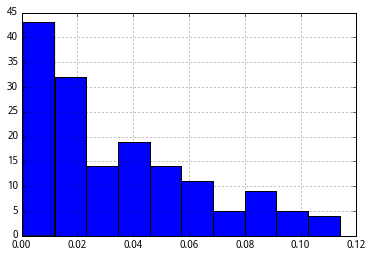

In [6]:
EffectTestresult['IC'].hist()

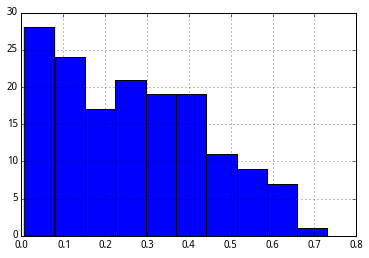

In [7]:
EffectTestresult['ICIR'].abs().hist()

In [8]:
#筛选有效因子
# IC大于0.07，ICIR大于0.4，测试一，测试二-胜者组，测试三-胜者组，必须通过
# 测试二、测试三中要至少通过3个。
index_ic=EffectTestresult['IC']>0.07
index_icir=EffectTestresult['ICIR'].abs()>0.4
test_index=all(EffectTestresult.iloc[:,[2,3,5]],axis=1)
test2_index=sum(EffectTestresult.iloc[:,3:6],axis=1)>=3
filter_index=index_ic&index_icir&test_index&test2_index
EffectFactorresult=EffectTestresult.loc[filter_index,:]
# 生成有效因子字典
EffectFactor=list(EffectFactorresult.index)
Effect_factor_dict={key:value for key,value in all_factor_dict.items() if key in EffectFactor}
EffectFactorresult

,IC,ICIR,测试一,测试二-胜者组,测试二-败者组,测试三-胜者组,测试三-败者组
EBITDA,0.082254,0.470848,True,True,True,True,False
VOL120,0.104381,-0.571012,True,True,True,True,True
VOL240,0.114044,-0.592253,True,True,True,True,True
net_profit_ttm,0.084305,0.414241,True,True,True,True,False
np_parent_company_owners_ttm,0.083724,0.409508,True,True,True,True,False
operating_profit_per_share_ttm,0.083361,0.477216,True,True,True,True,False
operating_profit_ttm,0.087531,0.420166,True,True,True,True,False
retained_earnings,0.098521,0.514923,True,True,True,True,True
sharpe_ratio_60,0.097450,0.609436,True,True,True,True,False
total_profit_ttm,0.086535,0.425337,True,True,True,True,True


In [9]:
def Group_Score_calculator(factor,univ_dict,signal,GroupNum=20):
    
    Score_df=pd.DataFrame(index=list(factor.index),columns=list(factor.columns))

    for date in sorted(list(univ_dict.keys())):    #这个也是个循环
        univ=univ_dict[date]
        univ=list(set(univ)&set(factor.loc[date].dropna().index))
        factor_se_stock=list(factor.loc[date,univ].to_frame('a').sort('a',ascending=False).index)
        N=len(factor_se_stock)
        for i in range(GroupNum):
            group_stock=factor_se_stock[int(N/GroupNum*i):int(N/GroupNum*(i+1))]
            if signal=='ascending':
                Score_df.loc[date,group_stock]=i
            else:
                Score_df.loc[date,group_stock]=GroupNum-i  
   
    return Score_df  

# 计算相关性矩阵
def factor_corr_calculator(Group_Score_Dict,univ_dict):

    Group_Score_dict_by_day={}
    Group_Score_Corr_dict_by_day={}
    
    # 每日的因子序列
    for Date in sorted(list(univ_dict.keys())):
        Group_Score_df=pd.DataFrame()
        univ=univ_dict[Date]
        for Factor in list(Group_Score_dict.keys()):
            Group_Score_df=Group_Score_df.append(Group_Score_dict[Factor].loc[Date,univ].to_frame(Factor).T)
        Group_Score_dict_by_day[Date]=Group_Score_df.T.fillna(4.5)
        Group_Score_Corr_dict_by_day[Date]=Group_Score_dict_by_day[Date].corr()

    # 算平均数
    N=len(list(univ_dict.keys()))
    Group_Score_Corr=Group_Score_Corr_dict_by_day[sorted(list(univ_dict.keys()))[0]]
    for Date in sorted(list(univ_dict.keys()))[1:]:
        Group_Score_Corr=Group_Score_Corr+Group_Score_Corr_dict_by_day[Date]

    return np.round(Group_Score_Corr/N,2)

# 给因子赋值
Group_Score_dict={}
for key,factor in Effect_factor_dict.items():
    signal='ascending' if ic_ir_se[key]>0 else 'descending'
    Group_Score_dict[key]=Group_Score_calculator(factor,univ_dict,signal,20)

# 计算因子相关系数    
factor_corrmatrix=factor_corr_calculator(Group_Score_dict,univ_dict)
factor_corrmatrix    

,VOL240,retained_earnings,operating_profit_per_share_ttm,operating_profit_ttm,net_profit_ttm,VOL120,EBITDA,np_parent_company_owners_ttm,total_profit_ttm,sharpe_ratio_60
VOL240,1.00,0.31,0.08,0.22,0.24,0.93,0.20,0.23,0.24,0.13
retained_earnings,0.31,1.00,0.48,0.76,0.76,0.25,0.58,0.76,0.77,0.02
operating_profit_per_share_ttm,0.08,0.48,1.00,0.69,0.64,0.03,0.32,0.65,0.64,0.01
operating_profit_ttm,0.22,0.76,0.69,1.00,0.96,0.17,0.59,0.95,0.96,0.02
net_profit_ttm,0.24,0.76,0.64,0.96,1.00,0.18,0.59,0.98,0.99,0.02
VOL120,0.93,0.25,0.03,0.17,0.18,1.00,0.15,0.18,0.18,0.16
EBITDA,0.20,0.58,0.32,0.59,0.59,0.15,1.00,0.57,0.61,0.00
np_parent_company_owners_ttm,0.23,0.76,0.65,0.95,0.98,0.18,0.57,1.00,0.98,0.03
total_profit_ttm,0.24,0.77,0.64,0.96,0.99,0.18,0.61,0.98,1.00,0.02
sharpe_ratio_60,0.13,0.02,0.01,0.02,0.02,0.16,0.00,0.03,0.02,1.00


In [10]:
# 比较后去掉一些因子
# operating_profit_ttm,net_profit_ttm,np_parent_company_owners_ttm,VOL120
removed_factor=['operating_profit_ttm','net_profit_ttm','np_parent_company_owners_ttm','VOL120']
Effect_factor_dict={key:value.sort_index() for key,value in Effect_factor_dict.items() if key not in removed_factor}
Effect_factor_ic_df=ic_df.loc[:,list(Effect_factor_dict.keys())]

In [11]:
def plot_nav(all_return_df,index_return,key):
# Preallocate figures
    fig = plt.figure(figsize=(12,12))
    fig.set_facecolor('white')
    fig.set_tight_layout(True)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.grid()
    ax2.grid()
    ax1.set_ylabel(u"净值", fontsize=16)
    ax2.set_ylabel(u"对冲净值", fontsize=16)
    ax1.set_title(u"因子选股{} - 净值走势".format(key),fontsize=16)
    ax2.set_title(u"因子选股 - 对冲指数后净值走势", fontsize=16)
# preallocate data    
    date=list(all_return_df.index)
    sequence=all_return_df.columns
# plot nav
    for sq in sequence:
        nav=(1+all_return_df[sq]).cumprod()
        nav_excess=(1+all_return_df[sq]-index_return).cumprod()
        ax1.plot(date,nav,label=str(sq))
        ax2.plot(date,nav_excess,label=str(sq))
    ax1.legend(loc=0,fontsize=12)
    ax2.legend(loc=0,fontsize=12)
    
def polish(x):
    return '%.2f%%' % (x*100)

def result_stats(key,all_return_df,index_return):  

    # Preallocate result DataFrame
    sequences=all_return_df.columns

    cols = [(u'风险指标', u'Alpha'), (u'风险指标', u'Beta'), (u'风险指标', u'信息比率'), (u'风险指标', u'夏普比率'),
            (u'纯多头', u'年化收益'), (u'纯多头', u'最大回撤'), (u'纯多头', u'收益波动率'), 
            (u'对冲后', u'年化收益'), (u'对冲后', u'收益波动率')]
    columns = pd.MultiIndex.from_tuples(cols)
    result_df = pd.DataFrame(index = sequences,columns=columns)
    result_df.index.name = "%s" % (key)

    for sq in sequences:  #循环在这里开始

        # 净值
        return_data=all_return_df[sq]
        return_data_excess=return_data-index_return
        nav=(1+return_data).cumprod()
        nav_excess=(1+return_data_excess).cumprod()
        nav_index=(1+index_return).cumprod()

        # Beta
        beta=return_data.corr(index_return)*return_data.std()/index_return.std()
        beta_excess=return_data_excess.corr(index_return)*return_data_excess.std()/index_return.std()

        #年化收益
        daylength=(return_data.index[-1]-return_data.index[0]).days
        yearly_return=np.power(nav.iloc[-1],1.0*365/daylength)-1
        yearly_return_excess=np.power(nav_excess.iloc[-1],1.0*365/daylength)-1
        yearly_index_return=np.power(nav_index.iloc[-1],1.0*365/daylength)-1

        # 最大回撤 其实这个完全看不懂
        max_drawdown=max([1-v/max(1,max(nav.iloc[:i+1])) for i,v in enumerate(nav)])
        #max_drawdown_excess=max([1-v/max(1,max(nav_excess.iloc[:i+1])) for i,v in enumerate(nav_excess)])

        # 波动率
        vol=return_data.std()*sqrt(252)
        vol_excess=return_data_excess.std()*sqrt(252)

        # Alpha
        rf=0.04
        alpha=yearly_return-(rf+beta*(yearly_return-yearly_index_return))
        alpha_excess=yearly_return_excess-(rf+beta_excess*(yearly_return-yearly_index_return))

        # 信息比率
        ir=(yearly_return-yearly_index_return)/(return_data_excess.std()*sqrt(252))

        # 夏普比率
        sharpe=(yearly_return-rf)/vol

        # 美化打印

        alpha,yearly_return,max_drawdown,vol,yearly_return_excess,vol_excess=\
        map(polish,[alpha,yearly_return,max_drawdown,vol,yearly_return_excess,vol_excess])
        sharpe=round(sharpe,2)
        ir=round(ir,2)
        beta=round(ir,2)

        result_df.loc[sq]=[alpha,beta,ir,sharpe,yearly_return,max_drawdown,vol,yearly_return_excess,vol_excess]
    return result_df

def draw_excess_return(excess_return,key):
    excess_return_mean=excess_return[1:].mean()
    excess_return_mean.index = map(lambda x:int(x)+1,excess_return_mean.index)
    excess_plus=excess_return_mean[excess_return_mean>0]
    excess_minus=excess_return_mean[excess_return_mean<0]

    fig = plt.figure(figsize=(12, 6))
    fig.set_facecolor('white')
    ax1 = fig.add_subplot(111)
    ax1.bar(excess_plus.index, excess_plus.values, align='center', color='r', width=0.35)
    ax1.bar(excess_minus.index, excess_minus.values, align='center', color='g', width=0.35)
    ax1.set_xlim(left=0.5, right=len(excess_return_mean)+0.5)
    ax1.set_ylabel(u'超额收益', fontsize=16)
    ax1.set_xlabel(u'十分位分组', fontsize=16)
    ax1.set_xticks(excess_return_mean.index)
    ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], fontsize=14)
    ax1.set_yticklabels([str(x*100)+'0%' for x in ax1.get_yticks()], fontsize=14)
    ax1.set_title(u"因子选股分组超额收益{}".format(key), fontsize=16)
    ax1.grid()

/opt/conda/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


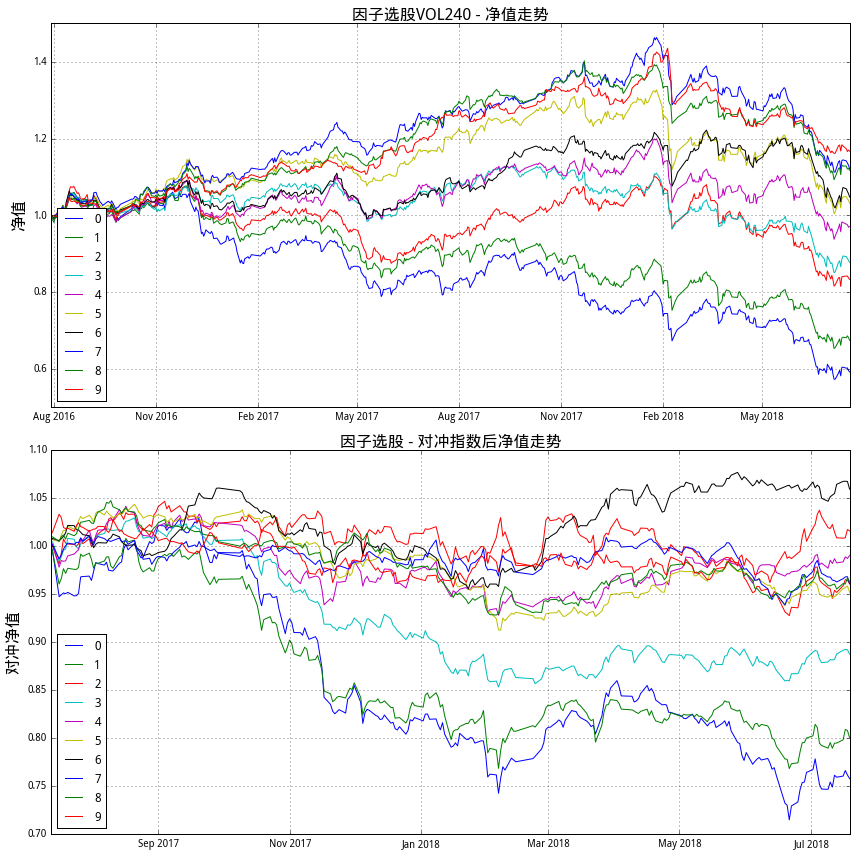

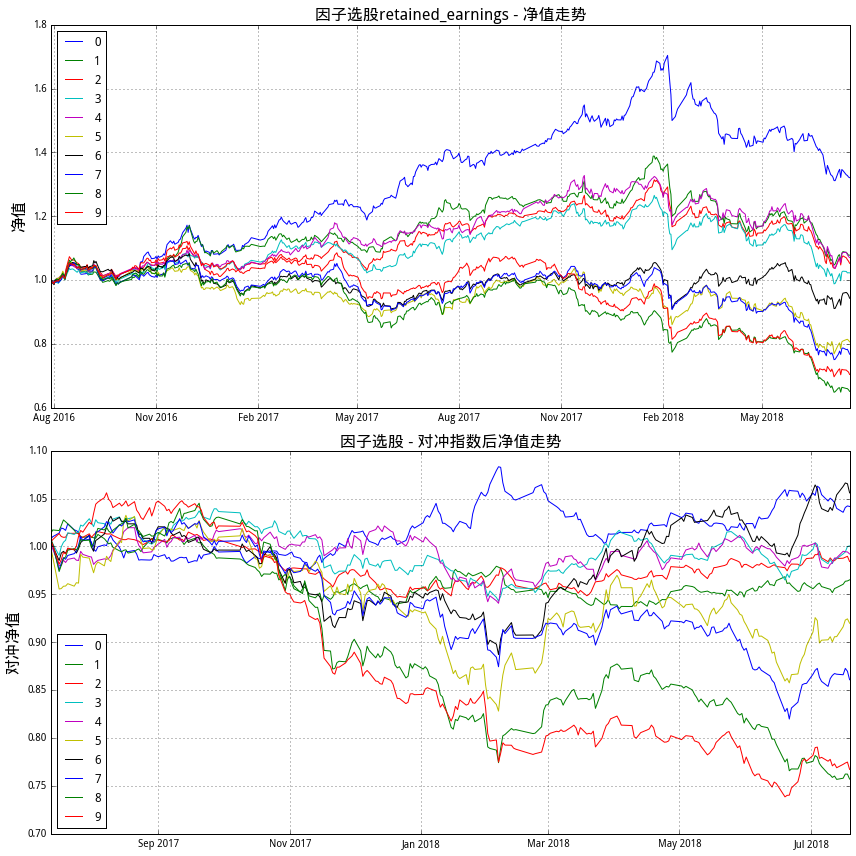

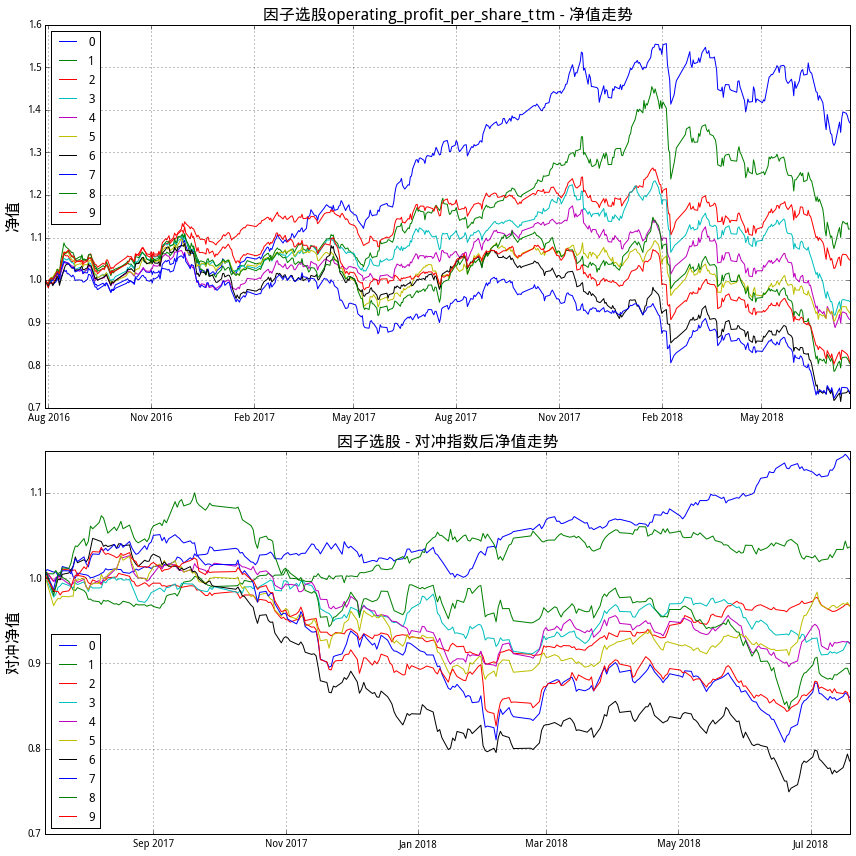

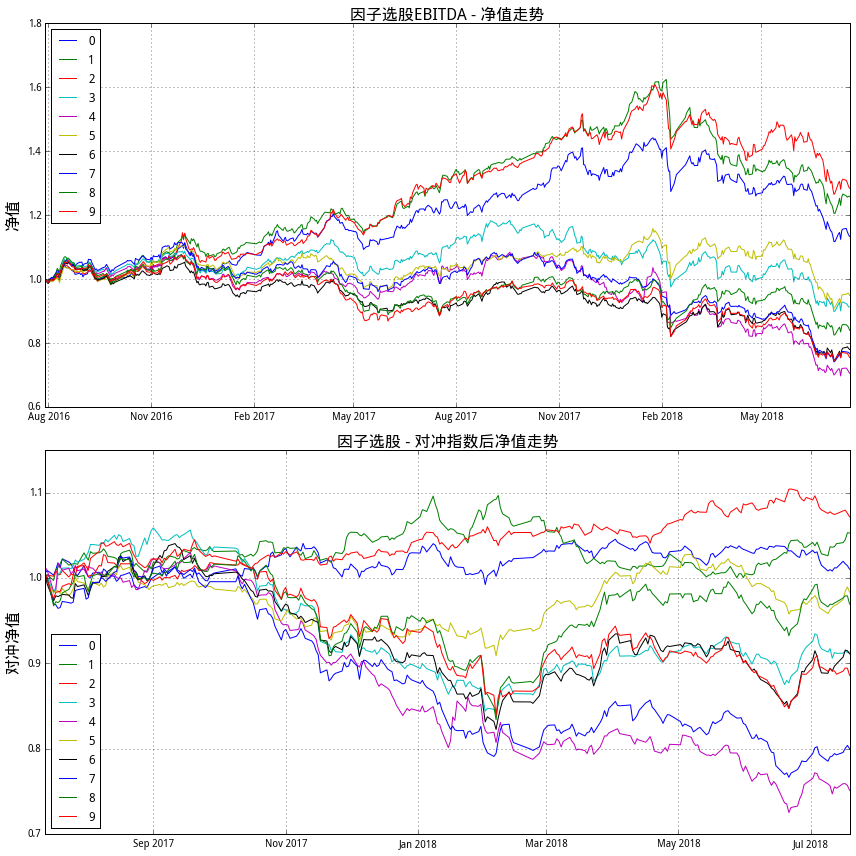

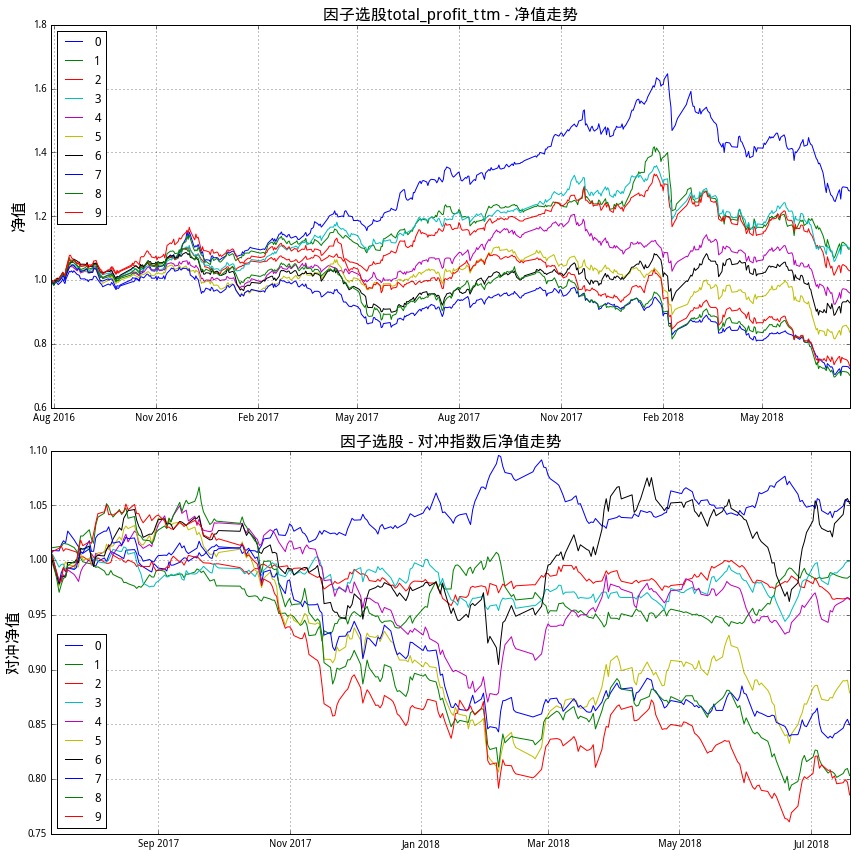

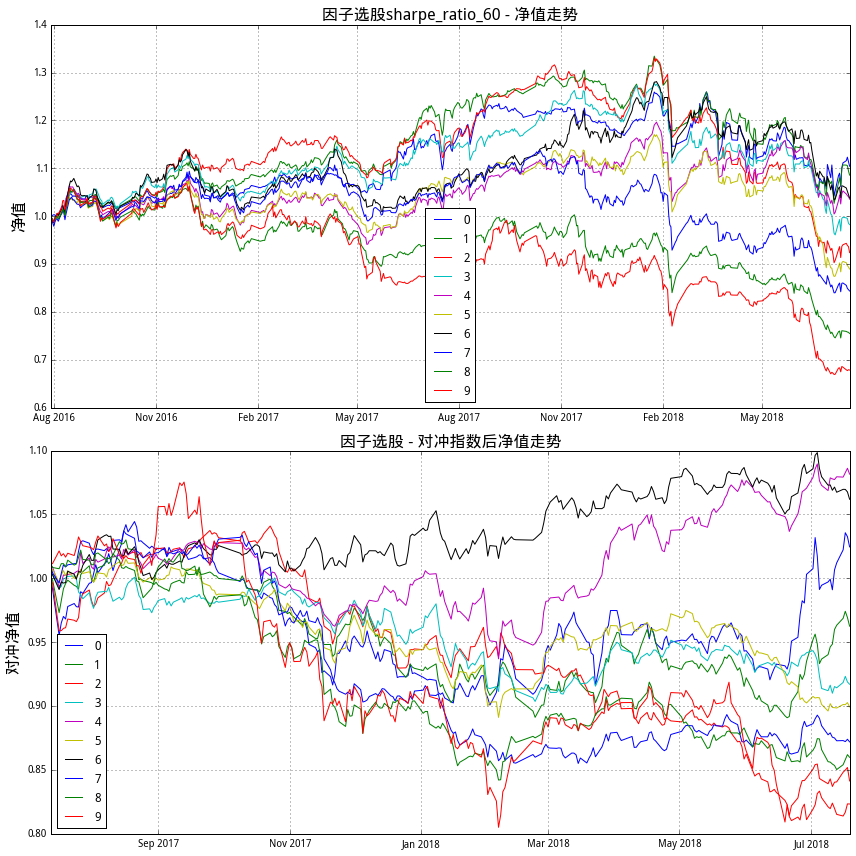

In [12]:
for key in list(Effect_factor_dict.keys()):
    plot_nav(all_Factor_Group_Return_dict[key],index_return,key)  

In [13]:
result_dict={}
for key in list(Effect_factor_dict.keys()):
    result_df=result_stats(key,all_Factor_Group_Return_dict[key],index_return)
    result_dict[key]=result_df
    print(result_df)

          风险指标                        纯多头                      对冲后        
         Alpha  Beta  信息比率  夏普比率     年化收益    最大回撤   收益波动率     年化收益   收益波动率
VOL240                                                                    
0       -8.90% -1.24 -1.24 -1.35  -23.34%  45.98%  20.22%  -13.13%  15.85%
1       -8.85% -1.05 -1.05 -1.18  -18.10%  39.37%  18.75%  -10.69%  13.85%
2       -8.20% -0.49 -0.49 -0.76   -8.86%  26.16%  17.01%   -2.02%  10.76%
3       -8.17% -0.31 -0.31 -0.69   -6.43%  24.71%  15.11%   -5.89%   9.20%
4       -7.28%  0.24  0.24 -0.35   -1.48%  21.83%  15.54%   -0.51%   9.01%
5       -6.81%  0.73  0.73 -0.16    1.58%  24.36%  14.70%   -2.49%   7.16%
6       -6.20%  0.75  0.75 -0.12    2.39%  16.61%  13.92%    2.96%   7.99%
7       -5.53%  1.29  1.29  0.14    5.96%  23.99%  13.91%   -2.02%   7.43%
8       -4.45%  1.31  1.31  0.15    5.77%  22.09%  11.74%   -1.89%   7.15%
9       -2.11%  1.22  1.22  0.39    8.15%  19.08%  10.61%    0.79%   9.65%
                      风险指

In [14]:
result_dict['VOL240']

风险指标                        纯多头                      对冲后        
         Alpha  Beta  信息比率  夏普比率     年化收益    最大回撤   收益波动率     年化收益   收益波动率
VOL240                                                                    
0       -8.90% -1.24 -1.24 -1.35  -23.34%  45.98%  20.22%  -13.13%  15.85%
1       -8.85% -1.05 -1.05 -1.18  -18.10%  39.37%  18.75%  -10.69%  13.85%
2       -8.20% -0.49 -0.49 -0.76   -8.86%  26.16%  17.01%   -2.02%  10.76%
3       -8.17% -0.31 -0.31 -0.69   -6.43%  24.71%  15.11%   -5.89%   9.20%
4       -7.28%  0.24  0.24 -0.35   -1.48%  21.83%  15.54%   -0.51%   9.01%
5       -6.81%  0.73  0.73 -0.16    1.58%  24.36%  14.70%   -2.49%   7.16%
6       -6.20%  0.75  0.75 -0.12    2.39%  16.61%  13.92%    2.96%   7.99%
7       -5.53%  1.29  1.29  0.14    5.96%  23.99%  13.91%   -2.02%   7.43%
8       -4.45%  1.31  1.31  0.15    5.77%  22.09%  11.74%   -1.89%   7.15%
9       -2.11%  1.22  1.22  0.39    8.15%  19.08%  10.61%    0.79%   9.65%

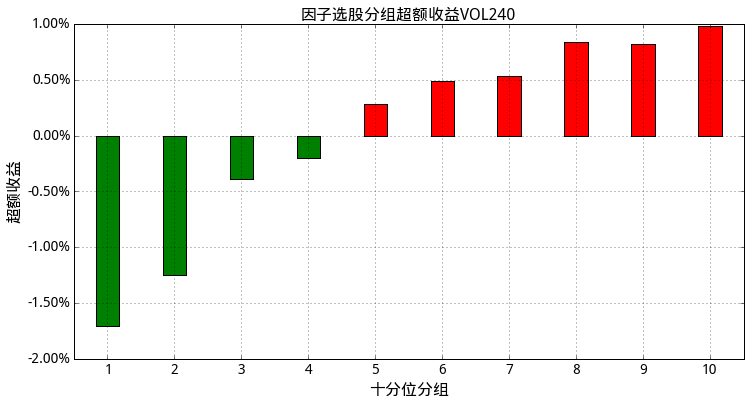

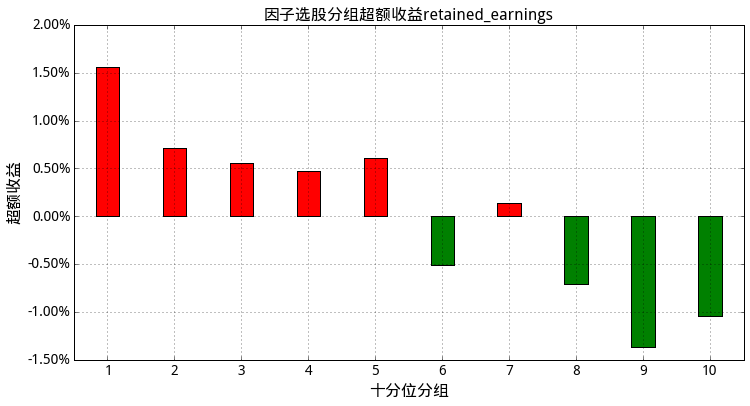

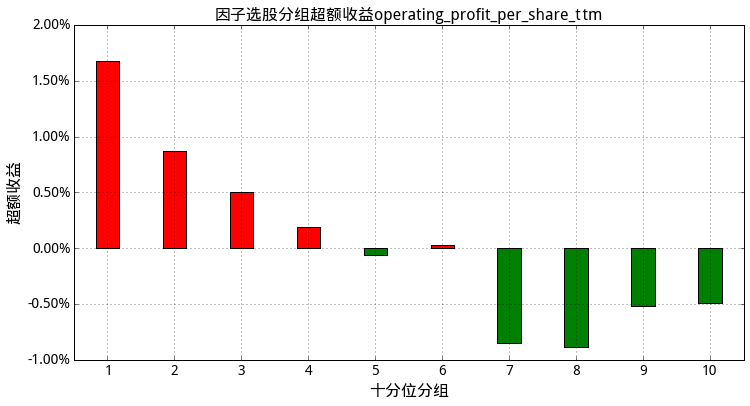

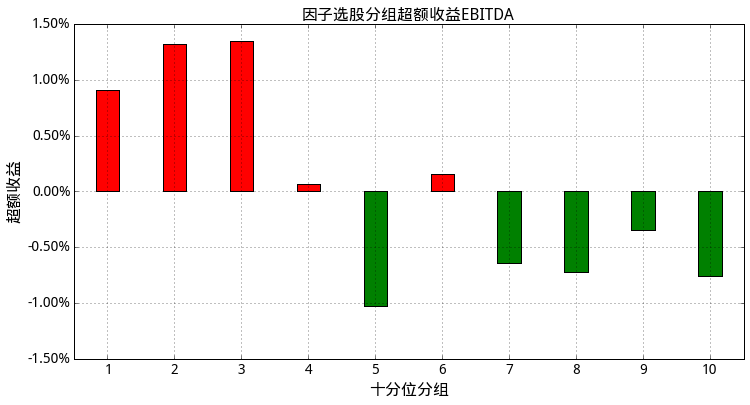

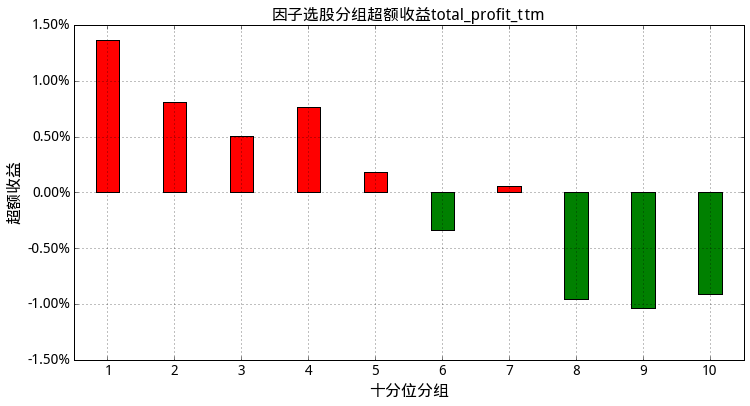

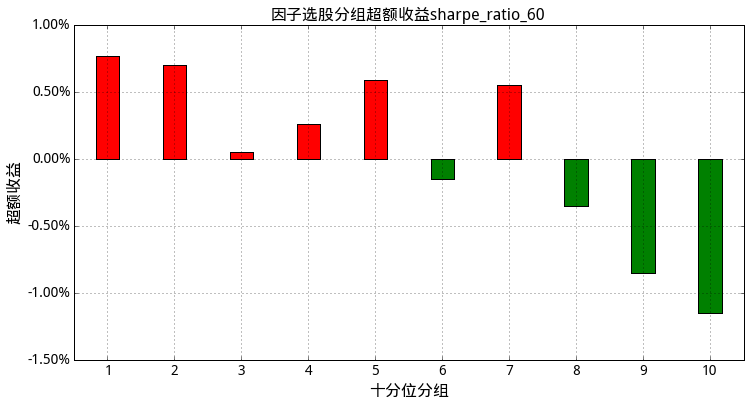

In [15]:
for key in list(Effect_factor_dict.keys()):
    draw_excess_return(Factor_Group_Excess_Return_dict[key],key)

In [16]:
print('\npickle序列化')
MyPackage_Final=[univ_dict,Effect_factor_ic_df.sort_index(),Effect_factor_dict]
pkl_file = open('MyPackage_Final.pkl', 'wb')
pickle.dump(MyPackage_Final,pkl_file,0)
pkl_file.close()


pickle序列化


In [1]:
# 读取因子
import pickle
pkl_file = open('MyPackage_Final.pkl', 'rb')
load_Package = pickle.load(pkl_file)
univ_dict,Effect_factor_ic_df,Effect_factor_dict=load_Package

In [4]:
date=sorted(list(univ_dict.keys()))[0]
univ=univ_dict[date]

factor_df=pd.DataFrame()

for key,value in Effect_factor_dict.items():
    #print(value.loc[date,univ].to_frame(key))
    
    factor_df=factor_df.append(value.loc[date,univ].to_frame(key).T)
    
factor_df    

,000825.XSHE,600031.XSHG,601555.XSHG,000568.XSHE,603993.XSHG,601988.XSHG,600068.XSHG,000651.XSHE,600030.XSHG,600109.XSHG,...,601788.XSHG,601899.XSHG,601958.XSHG,600309.XSHG,000895.XSHE,600188.XSHG,000858.XSHE,600837.XSHG,300133.XSHE,600373.XSHG
operating_profit_per_share_ttm,-1.618631,-0.8377003,-0.1274703,1.27296,-0.2116571,-1.411646,0.7516557,2.041962,1.165918,-0.3484557,...,1.256524,-0.160093,-0.3194905,2.02498,1.757221,-0.06606889,2.019028,0.5770212,-0.8259026,0.2727145
retained_earnings,0.1025844,1.216165,-1.173465,0.2281843,-0.7200523,-0.8506376,-0.2129582,1.841562,1.057246,-1.041136,...,0.3509719,1.708729,-0.8489289,0.234804,0.8343415,1.411199,1.84726,1.108222,-0.9495207,-0.6713877
total_profit_ttm,-1.563194,-1.026168,-0.4342355,-0.08517187,-0.1034573,-1.131646,1.114767,1.788046,0.6887023,-0.546003,...,0.99087,0.389533,-0.3258153,1.066882,1.765746,0.0181481,1.803667,0.7373394,-0.8105315,-0.5208317
EBITDA,0.1915273,0.2890074,-0.9211677,-0.2808993,-0.6893118,-0.8252032,1.368879,1.55039,0.4688841,-0.9445039,...,-0.6450379,1.172842,-1.048037,0.579318,0.9345179,1.19417,1.281237,0.6690919,-1.158852,0.1803311
VOL240,-0.8115715,-0.6657949,0.8833762,-0.4956583,-0.3471698,-1.420999,-0.2988302,-0.750732,0.5841439,1.109748,...,0.05825871,-0.3027226,-0.7031693,-0.9380701,-0.8571352,-1.062019,-0.924301,-0.249901,0.5628106,-0.732002
sharpe_ratio_60,-0.09624869,0.924179,-1.018296,-0.8363705,-1.373402,1.844343,-0.1708267,-0.9092627,0.3324075,-0.4502159,...,-0.7382549,-1.117275,-1.315177,-0.5591805,-0.295113,-1.645808,-0.5708715,0.8229273,-1.249383,-0.4442434


In [14]:
stocklist=factor_df.multiply(Effect_factor_ic_df.loc[date,:],axis=0).sum().to_frame('a').sort('a',ascending=False).index

In [10]:
Effect_factor_ic_df.loc[date,:]

VOL240                            0.038032
retained_earnings                -0.081406
operating_profit_per_share_ttm   -0.121700
EBITDA                           -0.080509
total_profit_ttm                 -0.141218
sharpe_ratio_60                   0.144803
Name: 2016-07-29, dtype: float64

In [20]:
list(Effect_factor_dict.keys())

['operating_profit_per_share_ttm',
 'retained_earnings',
 'total_profit_ttm',
 'EBITDA',
 'VOL240',
 'sharpe_ratio_60']